In [139]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import copy
import os
import xgboost as xgb

In [141]:
from cycler import cycler
my_cycler = (cycler(color=['#94c8d8','#FE9A84','#296540','#E63F39','#C3AAD1',
              '#D5AC5A','#F4B6C3','#B4BCCA','#DBD468','#B1D3E1','#8b1821']))

fh = 13
plt.rcParams['figure.figsize'] = (18,12)
plt.rcParams['axes.prop_cycle'] = my_cycler
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 9#12
plt.rcParams['legend.fontsize'] = fh
plt.rcParams['axes.labelsize'] = fh
plt.rcParams['xtick.labelsize'] = fh
plt.rcParams['ytick.labelsize'] = fh
plt.rcParams['axes.titlesize'] = fh
plt.rcParams['figure.titlesize'] = fh

In [172]:
class metrics():
    def __init__(self):
        self.varns = ['SWCF global ceres_ebaf_toa_v4.1','LWCF global ceres_ebaf_toa_v4.1','PRECT global GPCP_v2.3',
           'FLNS global ceres_ebaf_surface_v4.1','U-200mb global ERA5','PSL global ERA5','Z3-500mb global ERA5',
           'TREFHT land ERA5','T-200mb global ERA5','SST global HadISST_PI']
        self.shortname = ['SWCF','LWCF','PRECT','FLNS','U200','PSL','Z500','TREFHT','T200','SST']
        self.const = 'RESTOM global ceres_ebaf_toa_v4.1'
        self.all_varns = ['PRECT global GPCP_v2.3','FLUT global ceres_ebaf_toa_v4.1','FSNTOA global ceres_ebaf_toa_v4.1',
                          'SWCF global ceres_ebaf_toa_v4.1','LWCF global ceres_ebaf_toa_v4.1','NETCF global ceres_ebaf_toa_v4.1',
                          'FLNS global ceres_ebaf_surface_v4.1','FSNS global ceres_ebaf_surface_v4.1','LHFLX global ERA5',
                          'SHFLX global ERA5','PSL global ERA5','U-850mb global ERA5','U-200mb global ERA5',
                          'Z3-500mb global ERA5','T-850mb global ERA5','T-200mb global ERA5',
                          'TAUXY ocean ERA5','TREFHT land ERA5','SST global HadISST_PI']
        self.all_shortname = ['PRECT','FLUT','FSNTOA','SWCF','LWCF','NETCF','FLNS','FSNS','LHFLX','SHFLX',
                              'PSL','U850','U200','Z500','T850','T200','TAUXY','TREFHT','SST_PI']
        
        self.cntl_rmse = np.array([10.738,4.61,0.967,9.319,3.036,2.181,0.235,2.575,2.486,1.08 ])
        self.cntl_all_rmse = np.array([ 0.967,  5.659,  9.933, 10.738,  4.61 ,  9.874,  9.319, 11.423,
                                        14.186,  8.689,  2.181,  1.266,  3.036,  0.235,  1.617,  2.486,
                                        0.024,  2.575,  1.08])
        self.iceA_def = 11785647.64
        self.iceA_obs = 9950291.79
        self.iceV_def = 23.80
        self.iceV_obs = 20.03

    def get_score(self, path_output_case):
        path_base = f"/home/ac.tzhang/fs0_large/E3SM_archive/"
        path_diag = "20230223.NGD_v3atm.piControl.tune/e3sm_diags/atm_monthly_180x360_aave/model_vs_obs_0001-0010/viewer/table-data"
        data_diag = pd.read_csv(f'/{path_base}/{path_output_case}/{path_diag}/ANN_metrics_table.csv').set_index('Variables')
        path_mpas = "post/analysis/mpas_analysis/ts_0001-0010_climo_0001-0010/timeseries/"

        
        #tuning varialbs
        data_tune = data_diag.loc[self.varns]
        sd_obs = data_tune['Ref._STD'].values
        sd_mod = data_tune['Test_STD'].values
        corr =   data_tune['Correlation'].values
        rmse =   data_tune['RMSE'].values / self.cntl_rmse
        bias =   data_tune['Mean_Bias'].values
    
        ts = ((((sd_obs/sd_mod + sd_mod/sd_obs) ** 2) * (2 ** 4))/(4 * (1 + corr) ** 4))
        corr_sum = np.sum(corr)
        rmse_sum = np.sum(rmse)
        ts_sum = np.sum(ts)
        bias_sum = np.sum(bias)
    
        #secIce area/Volumn
    
        fid = xr.open_dataset(f'{path_base}/{path_output_case}/{path_mpas}/seaIceAreaVolNH.nc')
        iceA_mod = np.mean(fid['iceArea'].values / (1000 ** 2))
        iceV_mod = np.mean(fid['iceVolume'].values / (1000 ** 3 * 1000))
    
        iceA_score = (iceA_mod - self.iceA_obs) / (self.iceA_def - self.iceA_obs)
        iceV_score = (iceV_mod - self.iceV_obs) / (self.iceV_def - self.iceV_obs)

        #constraint variables
        constrain = data_diag.loc[self.const]['Test_mean']
    
        score = rmse_sum + 0.1 * np.abs(iceA_score) + 0.1 * np.abs(iceV_score) + np.abs(constrain)
        #print(f'case{caseid-9}: total_score={score:.2f},tylor_score={ts:.2f},iceA_score={iceA_score:.2f},iceV_score={iceV_score:.2f},constrain={constrain:.2f}')

        tmp = {}
        tmp['total_score'] = score
        tmp['tylor_score'] = ts_sum
        tmp['Corr'] = corr_sum
        tmp['RMSE'] = rmse_sum
        tmp['RMSE_SST'] = rmse[-1]
        tmp['TS_SST'] = ts[-1]
        tmp['CORR_SST'] = corr[-1]
        tmp['iceA_score'] = iceA_score
        tmp['iceV_score'] = iceV_score
        tmp['RESTOM'] = constrain
        tmp['Bias'] = bias[-1]
        tmp = pd.DataFrame(tmp, index=[path_output_case])
        return tmp,rmse,ts,corr,bias

    def get_scoreset(self):
        score_dataset = pd.DataFrame()
        rmse_dataset,ts_dataset,corr_dataset,bias_dataset = [],[],[],[]
        
        for caseid in range(9,110):
            tmp,rmse,ts,corr,bias = self.get_score(f'workdir.{caseid}')        
            score_dataset = pd.concat([score_dataset,tmp])
            rmse_dataset.append(rmse)
            ts_dataset.append(ts)
            corr_dataset.append(corr)
            bias_dataset.append(bias)

        tmp,rmse,ts,corr,bias = self.get_score('cntl')
        score_dataset = pd.concat([score_dataset,tmp])
        #score_dataset.to_csv('score_dataset.csv')
        #return score_dataset.sort_values(by='RMSE'),rmse_dataset,ts_dataset,corr_dataset,bias_dataset
        return score_dataset,rmse_dataset,ts_dataset,corr_dataset,bias_dataset

    def compare_cntl(self,cases,casens,markers):
        fig, ax = plt.subplots(1,1,figsize=(9,4))
        score_pd = pd.DataFrame()
        
        for i,case in enumerate(cases):
            diag_data = pd.read_csv(case).set_index('Variables')
            diag_data = diag_data.loc[self.all_varns]

            rmse = diag_data['RMSE'].values / self.cntl_all_rmse
            score_pd[casens[i]] = rmse 
            ax.scatter(self.all_shortname, rmse, label=casens[i],marker=markers[i])

        ax.set_xticklabels(self.all_shortname,rotation=45)
        ax.legend()
        ax.set_ylabel('RMSE')

        score_pd['var'] = self.all_shortname
        return score_pd.set_index('var')

In [173]:
m = metrics()
score_dataset,rmse_dataset,ts_dataset,corr_dataset,bias_dataset = m.get_scoreset()
rmse_dataset = np.array(rmse_dataset)
ts_dataset = np.array(ts_dataset)
corr_dataset = np.array(corr_dataset)
bias_dataset = np.array(bias_dataset)
pd.set_option('display.max_rows', None)

#score_dataset = score_dataset.loc[cases,:]

In [174]:
score_dataset.sort_values(by='total_score')

,total_score,tylor_score,Corr,RMSE,RMSE_SST,TS_SST,CORR_SST,iceA_score,iceV_score,RESTOM,Bias
workdir.107,9.737266,12.585180,9.154,9.403415,1.020370,1.026004,0.992,0.681720,0.156795,0.250,1.201
workdir.86,9.753233,12.645692,9.130,9.573638,1.026852,1.024760,0.992,0.690377,0.075576,0.103,1.206
workdir.80,9.848490,13.236958,9.048,9.468940,0.997222,1.030058,0.991,0.653434,0.322065,-0.282,1.008
workdir.99,9.884355,12.472691,9.164,9.612122,1.009259,1.026687,0.992,0.365688,-0.556641,0.180,1.196
workdir.84,10.093701,12.476310,9.130,9.686507,1.026852,1.028622,0.991,0.889615,1.072321,-0.211,1.112
workdir.61,10.096647,13.337945,9.047,9.800728,0.978704,1.027475,0.992,0.879185,0.310002,-0.177,1.136
workdir.75,10.104710,13.121961,9.044,9.864243,1.065741,1.027480,0.991,0.644285,0.240387,0.152,1.228
workdir.69,10.156661,13.274225,9.036,9.881319,0.996296,1.028577,0.992,0.575406,-0.358016,-0.182,0.974
workdir.37,10.165816,13.158112,9.078,9.740695,0.976852,1.026661,0.992,0.803899,0.167310,-0.328,1.090
workdir.41,10.168108,13.486564,9.032,9.618382,0.963889,1.028380,0.992,0.941180,0.606081,-0.395,1.036


In [175]:
score_dataset.sort_values(by='RMSE_SST')

,total_score,tylor_score,Corr,RMSE,RMSE_SST,TS_SST,CORR_SST,iceA_score,iceV_score,RESTOM,Bias
workdir.79,10.247378,13.186976,9.045,9.885819,0.957407,1.030705,0.992,0.609567,-0.146025,-0.286,0.854
workdir.105,11.516122,14.856227,8.888,10.710982,0.962963,1.032068,0.992,0.939860,0.621533,-0.649,0.923
workdir.42,10.168108,13.486564,9.032,9.618382,0.963889,1.028380,0.992,0.941180,0.606081,-0.395,1.036
workdir.41,10.168108,13.486564,9.032,9.618382,0.963889,1.028380,0.992,0.941180,0.606081,-0.395,1.036
workdir.106,11.625380,14.677601,8.905,10.639993,0.964815,1.031971,0.992,0.926792,0.587079,-0.834,0.906
workdir.81,10.933396,14.560222,8.911,10.484697,0.968519,1.030798,0.992,0.798217,0.208773,-0.348,0.971
workdir.74,11.763195,14.721264,8.915,10.727883,0.970370,1.030490,0.992,1.025930,0.947187,-0.838,0.799
workdir.108,10.274048,13.749102,9.002,9.904598,0.972222,1.032264,0.992,0.870953,0.313554,-0.251,0.956
workdir.65,10.509227,13.093151,9.051,10.378580,0.974074,1.026946,0.992,0.771581,-0.104883,0.043,1.158
workdir.71,10.244247,13.194009,9.035,9.990938,0.975000,1.028520,0.992,0.691646,-0.051446,-0.179,1.043


In [176]:
score_dataset.sort_values(by='RMSE')

,total_score,tylor_score,Corr,RMSE,RMSE_SST,TS_SST,CORR_SST,iceA_score,iceV_score,RESTOM,Bias
workdir.107,9.737266,12.585180,9.154,9.403415,1.020370,1.026004,0.992,0.681720,0.156795,0.250,1.201
workdir.80,9.848490,13.236958,9.048,9.468940,0.997222,1.030058,0.991,0.653434,0.322065,-0.282,1.008
workdir.86,9.753233,12.645692,9.130,9.573638,1.026852,1.024760,0.992,0.690377,0.075576,0.103,1.206
workdir.99,9.884355,12.472691,9.164,9.612122,1.009259,1.026687,0.992,0.365688,-0.556641,0.180,1.196
workdir.42,10.168108,13.486564,9.032,9.618382,0.963889,1.028380,0.992,0.941180,0.606081,-0.395,1.036
workdir.41,10.168108,13.486564,9.032,9.618382,0.963889,1.028380,0.992,0.941180,0.606081,-0.395,1.036
workdir.84,10.093701,12.476310,9.130,9.686507,1.026852,1.028622,0.991,0.889615,1.072321,-0.211,1.112
workdir.37,10.165816,13.158112,9.078,9.740695,0.976852,1.026661,0.992,0.803899,0.167310,-0.328,1.090
workdir.15,10.577222,11.907932,9.266,9.764673,1.165741,1.021733,0.992,0.563928,-0.051561,0.751,1.526
workdir.43,10.412310,13.368491,9.036,9.784581,1.028704,1.026843,0.991,0.951896,1.175393,-0.415,1.004


In [57]:
score_dataset.loc[['workdir.80','workdir.37','workdir.79','cntl'],:]

,total_score,tylor_score,Corr,RMSE,RMSE_SST,TS_SST,CORR_SST,iceA_score,iceV_score,RESTOM,Bias
workdir.80,9.848490,13.236958,9.048,9.468940,0.997222,1.030058,0.991,0.653434,0.322065,-0.282,1.008
workdir.37,10.165816,13.158112,9.078,9.740695,0.976852,1.026661,0.992,0.803899,0.167310,-0.328,1.090
workdir.79,10.247378,13.186976,9.045,9.885819,0.957407,1.030705,0.992,0.609567,-0.146025,-0.286,0.854
cntl,10.969868,14.021837,8.964,10.000000,1.000000,1.033878,0.992,1.000000,0.998684,-0.770,0.779


In [67]:
aa = score_dataset.loc[['workdir.80','workdir.37','workdir.79','cntl'],['total_score','RMSE_SST','iceA_score','iceV_score','RESTOM']]
#aa.set_index(['Best Total_Score in Opt.','Best in LHS','Best SST in Opt.','CNTL'])

aa.index = ['Best Total_Score in Opt.','Best in LHS','Best SST in Opt.','CNTL']
aa

,total_score,RMSE_SST,iceA_score,iceV_score,RESTOM
Best Total_Score in Opt.,9.848490,0.997222,0.653434,0.322065,-0.282
Best in LHS,10.165816,0.976852,0.803899,0.167310,-0.328
Best SST in Opt.,10.247378,0.957407,0.609567,-0.146025,-0.286
CNTL,10.969868,1.000000,1.000000,0.998684,-0.770


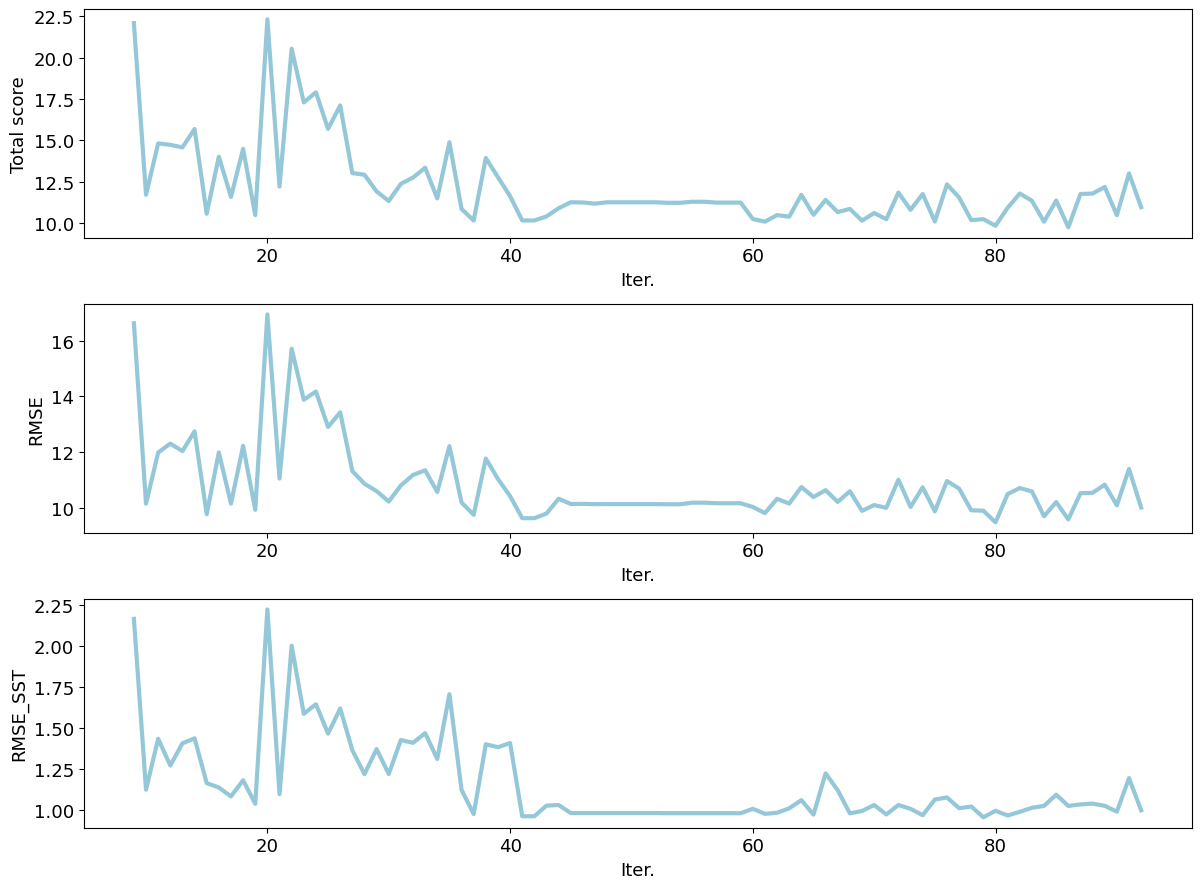

In [171]:
fig, ax = plt.subplots(3,1,figsize=(12,9))

opt_num = score_dataset.shape[0]
ax[0].plot(np.arange(9,opt_num+9),score_dataset.loc[:,'total_score'])
ax[0].set_xlabel('Iter.')
ax[0].set_ylabel('Total score')

ax[1].plot(np.arange(9,opt_num+9),score_dataset.loc[:,'RMSE'])
ax[1].set_xlabel('Iter.')
ax[1].set_ylabel('RMSE')

ax[2].plot(np.arange(9,opt_num+9),score_dataset.loc[:,'RMSE_SST'])
ax[2].set_xlabel('Iter.')
ax[2].set_ylabel('RMSE_SST')

plt.tight_layout()

        CNTL  Best in LHS (28)  Best Total_Score in Opt.  Best SST in Opt.
var                                                                       
PRECT    1.0          0.996898                  0.968976          1.048604
FLUT     1.0          1.101785                  0.993992          1.093479
FSNTOA   1.0          0.965670                  0.957515          1.071781
SWCF     1.0          0.930155                  0.925778          1.065003
LWCF     1.0          1.134056                  1.008243          1.169848
NETCF    1.0          0.912194                  0.901458          1.011242
FLNS     1.0          1.020710                  0.962550          0.983475
FSNS     1.0          0.994660                  0.972337          1.063819
LHFLX    1.0          1.061540                  1.041308          1.009446
SHFLX    1.0          0.973990                  1.003453          1.001496
PSL      1.0          1.090784                  0.996332          1.062357
U850     1.0          0.9

/tmp/ipykernel_4164673/707617674.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.all_shortname,rotation=45)


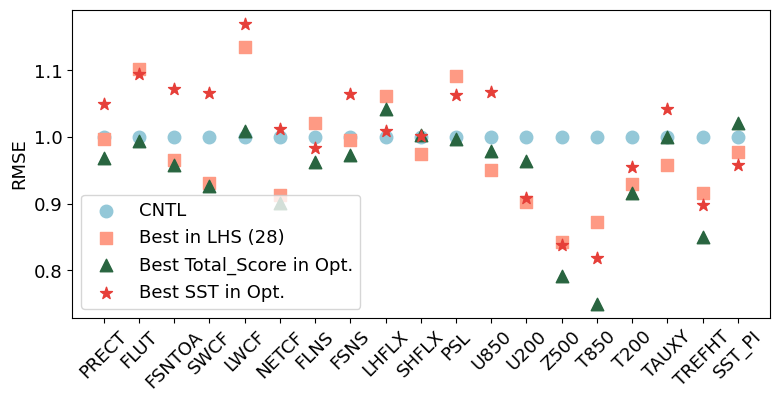

In [177]:
cases = ['/home/ac.tzhang/fs0_large/E3SM_archive/cntl/20230223.NGD_v3atm.piControl.tune/e3sm_diags/atm_monthly_180x360_aave/model_vs_obs_0001-0010/viewer/table-data/ANN_metrics_table.csv',
        '/home/ac.tzhang/fs0_large/E3SM_archive/workdir.37/20230223.NGD_v3atm.piControl.tune/e3sm_diags/atm_monthly_180x360_aave/model_vs_obs_0001-0010/viewer/table-data/ANN_metrics_table.csv',
        #'/home/ac.tzhang/fs0_large/E3SM_archive/workdir.15/20230223.NGD_v3atm.piControl.tune/e3sm_diags/atm_monthly_180x360_aave/model_vs_obs_0001-0010/viewer/table-data/ANN_metrics_table.csv',
        '/home/ac.tzhang/fs0_large/E3SM_archive/workdir.107/20230223.NGD_v3atm.piControl.tune/e3sm_diags/atm_monthly_180x360_aave/model_vs_obs_0001-0010/viewer/table-data/ANN_metrics_table.csv',
        '/home/ac.tzhang/fs0_large/E3SM_archive/workdir.79/20230223.NGD_v3atm.piControl.tune/e3sm_diags/atm_monthly_180x360_aave/model_vs_obs_0001-0010/viewer/table-data/ANN_metrics_table.csv'
        ]

casens = ['CNTL','Best in LHS (28)','Best Total_Score in Opt.','Best SST in Opt.']
markers = ['o','s','^','*']

aa = m.compare_cntl(cases,casens,markers)
print(aa)

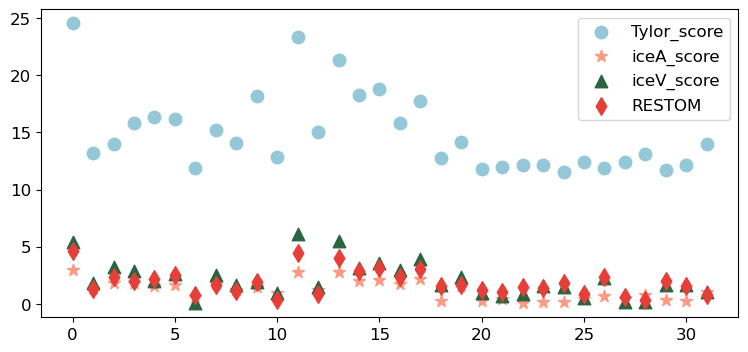

In [98]:
fig, ax = plt.subplots(1,1,figsize=(9,4))
ax.scatter(np.arange(score_dataset.shape[0]),score_dataset.loc[:,'tylor_score'],label='Tylor_score')
ax.scatter(np.arange(score_dataset.shape[0]),np.abs(score_dataset.loc[:,'iceA_score']),label='iceA_score',marker='*')
ax.scatter(np.arange(score_dataset.shape[0]),np.abs(score_dataset.loc[:,'iceV_score']),label='iceV_score',marker='^')
ax.scatter(np.arange(score_dataset.shape[0]),np.abs(score_dataset.loc[:,'RESTOM']),label='RESTOM',marker='d')
ax.legend()

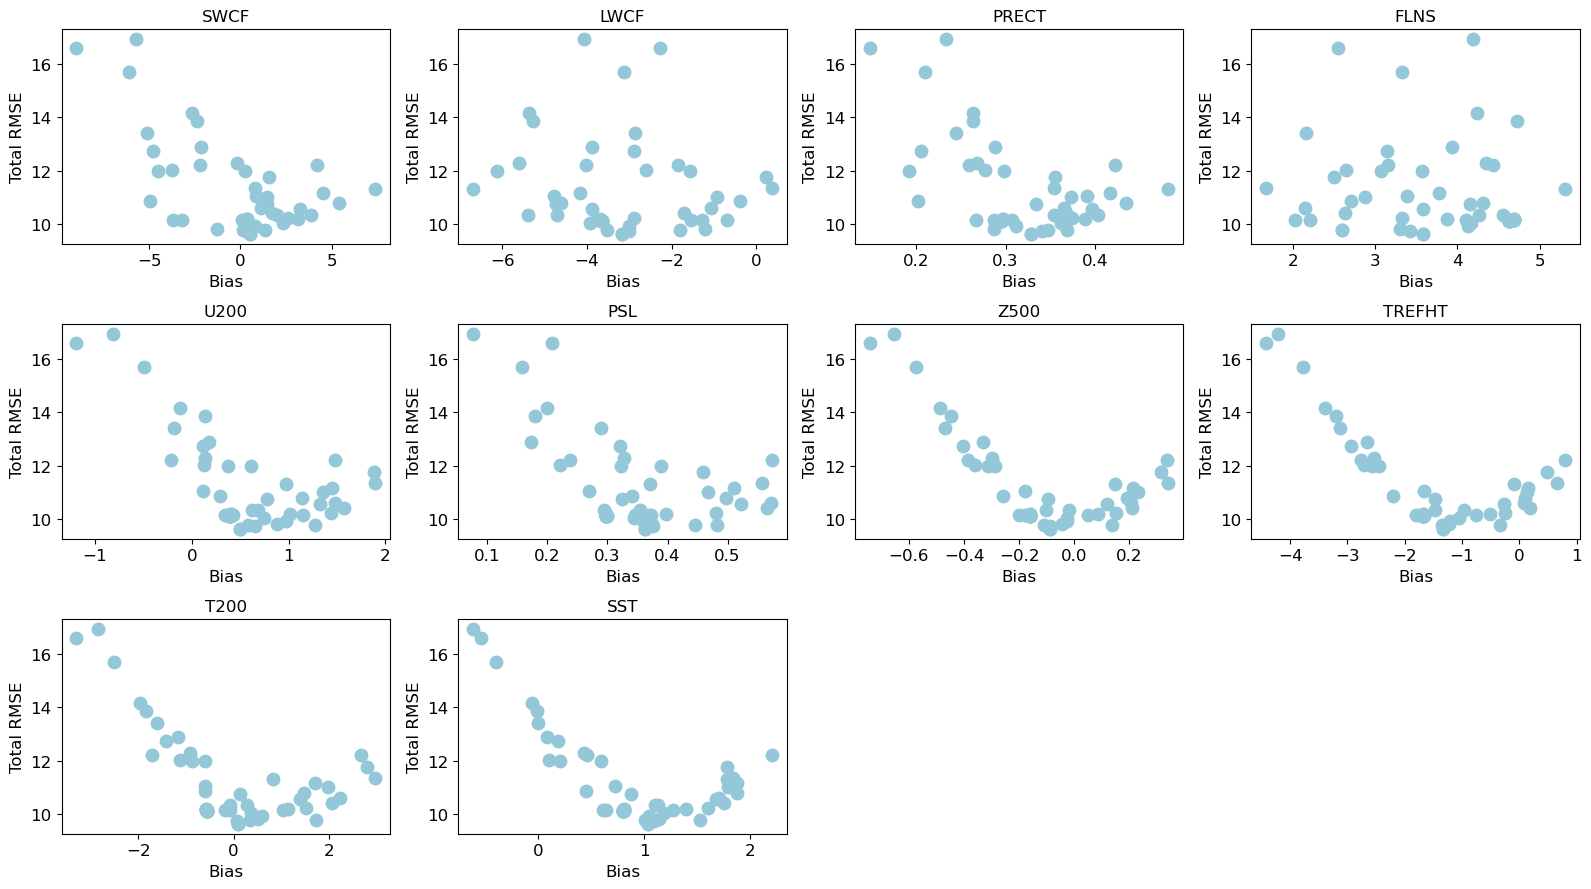

In [49]:
fig,axes = plt.subplots(3,4,figsize=(16,9))

for i in range(len(m.shortname)):
    axes[i//4][i%4].scatter(bias_dataset[:,i], score_dataset['RMSE'].iloc[:-1])
    axes[i//4][i%4].set_title(m.shortname[i])
    axes[i//4][i%4].set_xlabel('Bias')
    axes[i//4][i%4].set_ylabel('Total RMSE')

axes[2][2].set_axis_off()
axes[2][3].set_axis_off()
plt.tight_layout()

0.9188144062594935


Text(0.5, 1.0, 'RMSE_SST vs Total_Score, corr=0.92')

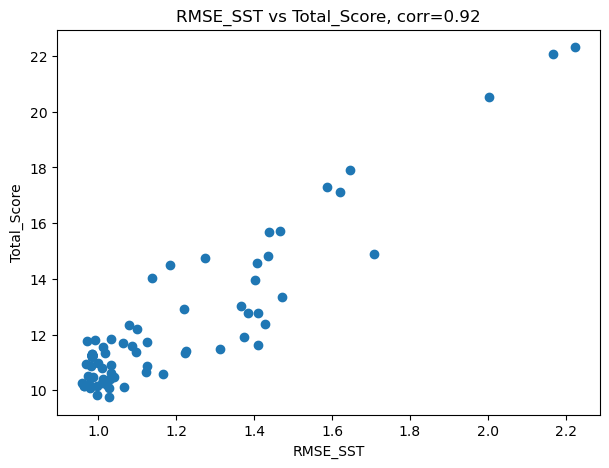

In [89]:
corr = score_dataset['RMSE_SST'].corr(score_dataset['total_score'])
print(corr)

fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.scatter(score_dataset['RMSE_SST'],score_dataset['total_score'])
ax.set_xlabel('RMSE_SST')
ax.set_ylabel('Total_Score')
ax.set_title(f'RMSE_SST vs Total_Score, corr={corr:.2f}')

In [70]:
p_names = ['clubb_c1','clubb_gamma_coef','clubb_c_k10','zmconv_tau','zmconv_dmpdz', 'zmconv_micro_dcs',
            'nucleate_ice_subgrid','p3_nc_autocon_expon','p3_qc_accret_expon','zmconv_auto_fac',
            'zmconv_accr_fac','zmconv_ke','cldfrc_dp1','p3_embryonic_rain_size','effgw_oro']

In [77]:
def get_paras(p_names, case_ids):
    p_dataset = pd.DataFrame()

    for c in case_ids:
        case_path = f'/home/ac.tzhang/fs0_large/E3SM_archive/{c}/atm_in'
        tmp = {}
        for pn in p_names:
            val_str = os.popen(f'grep -w {pn} {case_path}').read().split('=')[1]
            val = float(val_str)
            tmp[pn] = val

        tmp = pd.DataFrame(tmp,index=[c])
        p_dataset = pd.concat([p_dataset,tmp])

    return p_dataset

In [83]:
case_ids = ['workdir.80','workdir.37','workdir.79','cntl']

aa = get_paras(p_names,case_ids).T

In [85]:
aa.columns = ['Best Total_Score in Opt.','Best in LHS','Best SST in Opt.','CNTL']

In [86]:
aa

,Best Total_Score in Opt.,Best in LHS,Best SST in Opt.,CNTL
clubb_c1,2.351272,2.484653e+00,2.639779,2.400000
clubb_gamma_coef,0.259101,2.043747e-01,0.189913,0.120000
clubb_c_k10,0.455740,3.411327e-01,0.367802,0.350000
zmconv_tau,2955.327281,6.986406e+03,3022.719835,3600.000000
zmconv_dmpdz,-0.000916,-7.774434e-04,-0.000468,-0.000700
zmconv_micro_dcs,0.000233,1.883768e-04,0.000169,0.000150
nucleate_ice_subgrid,1.342054,1.306428e+00,1.397665,1.350000
p3_nc_autocon_expon,-1.523163,-1.430004e+00,-1.553199,-1.400000
p3_qc_accret_expon,1.152380,1.144492e+00,1.152733,1.150000
zmconv_auto_fac,6.057936,5.029281e+00,5.856580,7.000000


In [134]:
cases1 = [f'workdir.{i}' for i in range(9,45)]
cases2 = [f'workdir.{i}' for i in range(60,86)]
cases = cases1 + cases2 + ['cntl']
para_set = get_paras(p_names, cases)
print(para_set.shape)

(63, 15)


# sensitivity

In [135]:
score_dataset.loc[cases,:]

,total_score,tylor_score,Corr,RMSE,RMSE_SST,TS_SST,CORR_SST,iceA_score,iceV_score,RESTOM,Bias
workdir.9,22.088545,24.556394,8.466,16.626969,2.166667,1.077299,0.987,2.929220,5.456536,-4.623,-0.548
workdir.10,11.719694,13.228476,9.047,10.139520,1.125926,1.036518,0.990,1.320764,1.830977,-1.265,0.612
workdir.11,14.822415,14.028207,8.893,11.979544,1.436111,1.047781,0.987,1.787336,3.231381,-2.341,0.200
workdir.12,14.738727,15.810157,8.759,12.298994,1.273148,1.043960,0.989,1.863725,2.843606,-1.969,0.435
workdir.13,14.581872,16.345756,8.774,12.030980,1.408333,1.048338,0.990,1.571750,1.997177,-2.194,0.103
workdir.14,15.690785,16.219332,8.750,12.740131,1.438889,1.049697,0.988,1.671979,2.644566,-2.519,0.180
workdir.15,10.577222,11.907932,9.266,9.764673,1.165741,1.021733,0.992,0.563928,-0.051561,0.751,1.526
workdir.16,14.024215,15.210093,8.847,11.980407,1.138889,1.036817,0.990,1.764280,2.543803,-1.613,0.589
workdir.17,11.589244,14.102110,8.970,10.138293,1.085185,1.035198,0.990,1.233145,1.616358,-1.166,0.641
workdir.18,14.494960,18.187958,8.721,12.217515,1.183333,1.043131,0.991,1.479362,1.915091,-1.938,0.462


In [108]:
reg = xgb.XGBRegressor(n_estimators=600, nthread=8, max_depth=7)

[0.01905691 0.00728283 0.05573317 0.00283353 0.02483687 0.00423248
 0.00123297 0.03515742 0.7176872  0.00651196 0.00774252 0.01454123
 0.06568058 0.03195232 0.00551801]


Text(0.5, 1.0, 'Sensitivity for iceV_score')

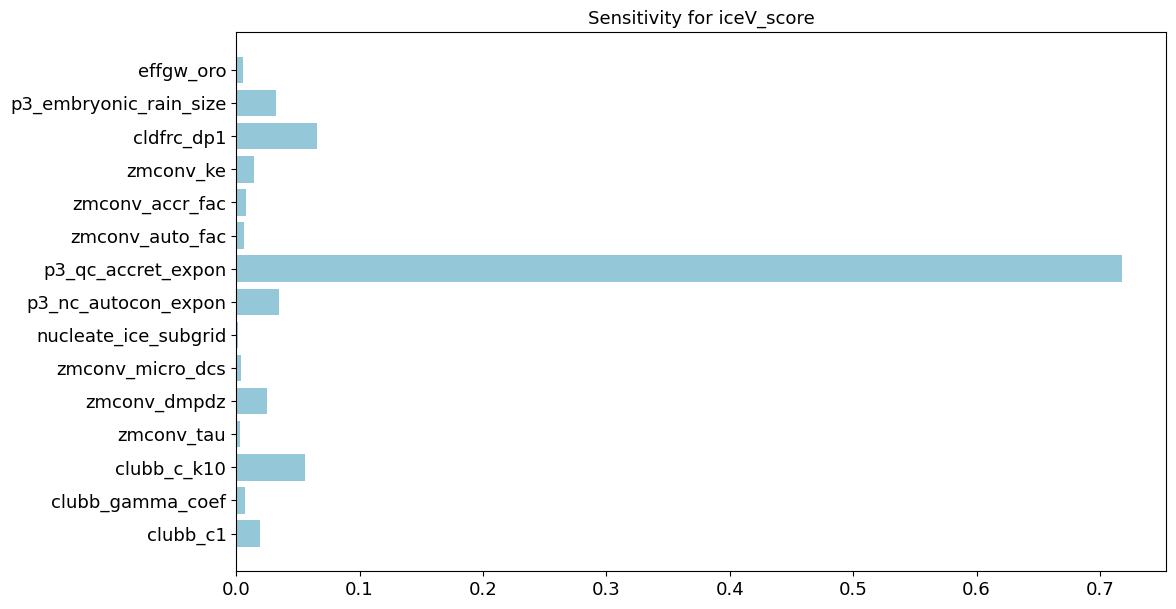

In [150]:
reg.fit(para_set.values, score_dataset.loc[cases,'iceV_score'])
print(reg.feature_importances_)

fig,axes = plt.subplots(1,1,figsize=(12,7))
axes.barh(para_set.columns, reg.feature_importances_)
axes.set_title('Sensitivity for iceV_score')